# Assignment 2: SoC Module Recommender System

## Instructions to submit the assignment

- Name your jupyter notebook as `Assignment2_[StudentID].ipynb`. For instance: `Assignment2_A0123873A.ipynb`
- Your solution notebook must contain the python code that we can run to verify the answers.
- Upload your jupyter notebook on LumiNUS in the *Assignment 1 Submissions* folder. The folder will close at 4pm on 02/04/2021. Late submissions will receive a penalty on the grade as follows:
  - late within 1 hour: 10% reduction in grade
  - late within 6 hours: 30% reduction in grade
  - late within 12 hours: 50% reduction in grade
  - late within 1 days: 70% reduction in grade
  - after 1 days: zero mark
- **This is an individual assessment. Refrain from working in groups.**

In this assignment we design a reccomendation engine. The recommendation engine suggests the students a module that closely matches the modules already taken by the student. The dataset comprices of two files:
- List of modules in the School of Computing 
- List of graduated students and the modules they had taken during their studies

# Loading the data

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.pipeline import Pipeline, FeatureUnion

'''
    YOU MUST USE THE RANDOM SEED WHEREVER NEEDED
'''
rng = np.random.default_rng(seed=42)

from google.colab import drive
drive.mount('/content/drive') # alternative is to drag and drop to google colab
courses = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Assignment2/courses.tsv", sep='\t')
students = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Assignment2/students.tsv", sep='\t')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
courses

,code,name,credits,workload,info,specialisation
0,CS1010,Programming Methodology,4,2-1-1-3-3,This module introduces the fundamental concept...,Core
1,CS1010FC/X,Programming Methodology,4,2-1-1-3-3,This module introduces the fundamental concept...,Core
2,CS1010E,Programming Methodology,4,2-1-1-3-3,This module introduces the fundamental concept...,Core
3,CS1010J,Programming Methodology,4,2-1-1-3-3,This module introduces the fundamental concept...,Core
4,CS1010S,Programming Methodology,4,2-1-1-3-3,This module introduces the fundamental concept...,Core
...,...,...,...,...,...,...
179,CS6281,Topics in Computer Science II,4,3-0-0-3-4,Topics will be of an advanced computer science...,NaN
180,CS6282,Topics in Computer Science III,4,3-0-0-3-4,Topics will be of an advanced computer science...,NaN
181,CS6283,Topics in Computer Science IV,4,3-0-0-3-4,Topics will be of an advanced computer science...,NaN
182,CS6284,Topics in Computer Science V,4,3-0-0-3-4,Topics will be of an advanced computer science...,NaN


In [36]:
students

,Unnamed: 0,GPA Range,Degree,Specialization,GPA,courses
0,0,4,1,3,4.072043,"CS5422,CS5223,CS4237,CS3281,CS6213,CS6211,CS32..."
1,1,4,1,1,4.919584,"CS6206,CS3241,CS5237,CS4350,CS3242,CS3281,CS42..."
2,2,4,1,0,4.628680,"CS5244,CS6270,CS6234,CS5223,CS3230,CS3284,CS22..."
3,3,4,1,1,4.018812,"CS5422,CS3220,CS3103,CS4224,CS4237,CS5248,CS32..."
4,4,3,0,1,3.340982,"CS6206,CS3241,CS5240,CS4350,CS5343,CS6243,CS62..."
...,...,...,...,...,...,...
995,995,4,0,3,4.753689,"CS6206,CS5238,CS4223,CS6211,CS5250,CS5224,CS53..."
996,996,4,0,1,4.763808,"CS2309,CS4215,CS1010FC/X,CS3211,CS5271,CS1281,..."
997,997,4,0,4,4.947150,"CS4243,CS3241,CS6207,CS4350,CS5343,CS6241,CS62..."
998,998,3,0,1,3.084214,"CS5422,CS3220,CS4344,CS2107,CS3283,CS6205,CS32..."


# Question 1: Creating the preprocessing pipeline

We want to create a sklearn pipeline to efficiently preprocess the data and prepare it for training a model. We use three different features in the `courses` data: `specialisation`, `info` and `workload`. We want to represent every feature in a numeric form and merge them to form a feature vector for every course. We do so in the following way:
- `specialisation` represents one of the six levels of the module. For instance: CS2103 is a Software Engineering (SE) specialisation module. Encode this categorical feature into a vector. The decision of handling missing values is left to you! *(Hint: You can use `MultiLabelBinerizer` to do so.)*
- `info` provides a short discription of the module. We want to convert it into a vector using CountVectorizer. *Don't forget to remove the stopwords* while doing so.
-  `workload` states the intended distribution of workload over lectures, tutorials, labs and self study. We want to find the workload as the sum of individual workloads. For instnce: 3-1-1-3-2 workload transforms to 10 hours.

Provide implementation for three classes that help us build the pipeline. `transformed_courses` should be a numpy array of shape `[n_courses X n_features]`.

                                                                                                   (6 marks)

In [37]:
class WorkloadTransformer:        
    def fit(self, X, y = None, **fit_params):
        return self
    
    def transform(self, X, y = None, **fit_params):
        word_load = X['workload'].astype('string')
        sum = word_load.apply(sum_hour).to_numpy().reshape(-1,1)
        return sum

def sum_hour(s):
    ans = 0
    for i in s.split('-'):
        ans += float(i)
    return ans

In [38]:
class InfoTransformer:        
    def fit(self, X, y = None, **fit_params):
        self.count_vect = CountVectorizer(stop_words = 'english').fit(X['info'])
        return self
    
    def transform(self, X, y = None, **fit_params):
        info_count = self.count_vect.transform(X['info']).toarray()
        return info_count

In [39]:
# class SpecTransformer:        
#     def fit(self, X, y = None, **fit_params):
#         #self.spec_n = X['specialisation'].apply(lambda x:x.split(','))
#         return self
    
#     def transform(self, X, y = None, **fit_params):
#         # I hadle the specilisation column, but i found the question after this all use the 'courses' which is the courses code.
#         # so i add the operation to operate the 'code' column.
#         # I find that the test data is from the 'courses' and it is the 'code' in courses
#         # spec_vevtor = MultiLabelBinarizer().fit_transform(X['specialisation'].astype('string').fillna(value="None"))
#         spec_vevtor = X['code'].astype('string')
#         spec_vevtor.apply(lambda a: int(a[2])).to_numpy().reshape(-1,1)
#         return spec_vevtor

class SpecTransformer:        
    def fit(self, X, y = None, **fit_params):
        return self
    
    def transform(self, X, y = None, **fit_params):
        return X['code'].astype('string').apply(lambda x: int(x[2])).to_numpy().reshape(-1,1)

In [40]:
featureTransformer = FeatureUnion([
    ('workload_processing', Pipeline([('wrkld', WorkloadTransformer())])),
    ('info_processing', Pipeline([('info', InfoTransformer())])),
    ('spec_processing', Pipeline([('spec', SpecTransformer())])),
])

featureTransformer.fit(courses)
transformed_courses = featureTransformer.transform(courses)

Now we prepare our testing data in the same way we preprocessed the course. `students` data comprises of 1000 students and a list of modules they have taken. 

Create `Xtest` and `Ytest` as two matrices. `Xtest`, of size `1000*5`, comprises of first five modules for every student in the list. `Ytest`, of size `1000*[remaining_modules]`, comprises of rest of the modules for every student in the list. 
We do so in order to assess the performance of the recommender. We assess the recommender based on its effectiveness to predict the modules given a list of five modules as the input.

For instance: 
- `Xtest[0] = ['CS2105', 'CS4222', 'CS6270', 'CS6205', 'CS4226']`
- `Ytest[0] = ['CS3282', 'CS6204', 'CS5223', 'CS3281', 'CS4344', 'CS5422', 'CS3237', 'CS5233']`.

<div align="right">(1 mark)</align>

In [41]:

stu = students['courses'].str
stu_courses = stu.split(',', expand = True).values


In [42]:
Xtest = stu_courses[:, 0:5]
print(Xtest)

[['CS5422' 'CS5223' 'CS4237' 'CS3281' 'CS6213']
 ['CS6206' 'CS3241' 'CS5237' 'CS4350' 'CS3242']
 ['CS5244' 'CS6270' 'CS6234' 'CS5223' 'CS3230']
 ...
 ['CS4243' 'CS3241' 'CS6207' 'CS4350' 'CS5343']
 ['CS5422' 'CS3220' 'CS4344' 'CS2107' 'CS3283']
 ['CS3202' 'CS4211' 'CS3205' 'CS3283' 'CS6280']]


In [43]:
Ytest = stu_courses[:, 5:]
print(Ytest)

[['CS6211' 'CS3282' 'CS2100' ... None None None]
 ['CS3281' 'CS4235' 'CS6207' ... None None None]
 ['CS3284' 'CS2281' 'CS6213' ... None None None]
 ...
 ['CS6241' 'CS6243' 'CS3242' ... None None None]
 ['CS6205' 'CS3284' 'CS3281' ... None None None]
 ['CS5271' 'CS3284' 'CS3217' ... None None None]]


For every student in `Xtest`, we need to transform the list of 5 modules to the feature space using the `featureTransformer` fit on the training data. For every module we will get a feature vector of size `n_features`. We add these feature vectors to get an aggregate feature vector for very student.

Write a function `getFeatureVector` that takes in the list of modules and `featureTransformer`. It returns the feature vector for the specified list of courses. For instance, `getFeatureVector(Xtest[0], featureTransformer)` will return a vector of size `n_features`.

<div align="right">(3 marks)</div>

In [44]:
def getFeatureVector(modules, featureTransformer):
    choose = courses['code'].isin(modules)
    courses_choose = courses[choose]
    feature_vector = featureTransformer.transform(courses_choose).sum(axis = 0)
    return feature_vector
getFeatureVector(Xtest[0], featureTransformer)

array([50.,  0.,  0., ...,  0.,  1., 23.])

# Question 2: Content based recommender

We can use a model as simple as K-nearest neighbour (KNN) to perform a content based recommendation. If we provide a list of 5 modules to the recommender, it provide us a list of modules that are similar to the specified modules.

`sklearn` provides `NearestNeighbors` as well as `KNeighborsClassifier`, both of which have a similar functionality. `NearestNeighbors` provides as an easy functionality to predict a list of K nearest neighbours. Therefore, we prefer it over `KNeighborsClassifier`. If we want to find K nearest points to a datapoint`d`, we need to use `n_neighbors` as K + 1 because the list includes `d` itself.

You can now train the model using the training data, which comprises of `transformed_courses` and with their codes as the labels. 
<div align="right">(1 mark)</div>

In [45]:
K = 5
model=NearestNeighbors(algorithm="brute",n_neighbors=K+1).fit(transformed_courses)


It is time to see our model in action. Let's see what modules our model reommends based on the modules taken by a student.

Write a function that takes in a *pre-trained* model of your choice as input and the list of modules. It returns the top-K recommendations of the model. Print the top 6 recommendations for the first student. 
<div align="right">(3 marks)</div>

In [46]:
def recommend(model, modulesTaken, k = 5):
    feature_vector = getFeatureVector(modulesTaken, featureTransformer).reshape(1,-1)
    dis, index = model.kneighbors(feature_vector)
    courses_code = courses['code'].to_numpy()
    index = [courses_code[i] for i in index[0][:k]]
    return index
# courses_code = courses['code'].to_numpy()
# def recommend(model, modulesTaken, k = 5):
#     modulesVector = getFeatureVector(modulesTaken, featureTransformer).reshape(1,-1)
#     distances, indices = model.kneighbors(modulesVector)
#     indices = [courses_code[i] for i in indices[0][:k]]
#     return indices
print(recommend(model, Xtest[0], 6))

['CS3203', 'CS3205', 'CS5223', 'CS6213', 'CS2020', 'CS3216']


# Question 3: Recommender evaluation

Is this the model any good?. To do so, we use **precision** and **recall** as our metrics. `Ytest` consists of true labels for every students. Using those labels as the ground truth, compute the precision and recall for every student. Write a code that prints values of average precision and recall for a specific value of `K` over the `students` dataset. Print the value of average precision and average recall for `K= 10`.

                                                                                                     (2 marks)

In [47]:

def precision_and_recall(ranked_list, truth_list):
    len_t, len_r = len(truth_list), len(ranked_list)
    tl, res = 0, 0
    while tl < len_t and truth_list[tl] != None:
        tl += 1

    for i in range(len_r):
        if ranked_list[i] in truth_list:
            res += 1
    ans1,ans2 = 0, 0
    if tl != 0:
      ans1 = 1.0 * len_r
      ans2 = 1.0 * tl
    else:
      ans1 = 1
      ans2 = 1
    precision = res / ans1
    recall = res / ans2
    return precision, recall

def  average(model, X_test, Y_test, K):
    len_X = len(X_test)
    total_precision,total_recall = 0, 0
    for i in range(len_X):
        precision, recall = precision_and_recall(recommend(model, X_test[i], K), Y_test[i])
        total_precision += precision
        total_recall += recall
    ave_precision = total_precision/len_X
    ave_recall = total_recall/len_X
    return ave_precision, ave_recall
    
ave_precision, ave_recall = average(NearestNeighbors(algorithm = "brute", n_neighbors = 10).fit(transformed_courses) , Xtest, Ytest, 10) 
print("Average_Precision: " + str(ave_precision))
print("Average_Recall: " + str(ave_recall))

Average_Precision: 0.06640000000000032
Average_Recall: 0.06805336173544405


We observe that both precision and recall is not really great. The reason might be igh feature dimension, which may even be noisy. Append the exisiting `featureTransformer` with a PCA to reduce the dimension. 

Print the value of average precision and recall for `K= 10` after the introduction of PCA.

                                                                                                     (2 marks)

Text(0, 0.5, 'cumulative explained variance')

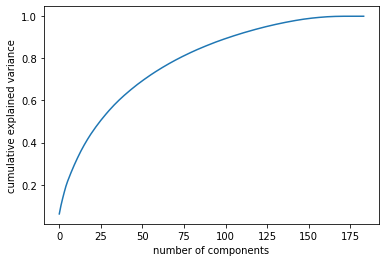

In [48]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
scaler = StandardScaler()
scaler.fit_transform(transformed_courses)
pca = PCA(random_state = rng)
pca.fit(transformed_courses)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

Extend the code to perform a grid search for the value of `K` that provides the best `F1_score`. Try for values of K from 1 to 10.

                                                                                                     (2 marks)

In [49]:
featureTransformer = Pipeline([('feats', featureTransformer), ('pca', pca)])
new_courses = featureTransformer.fit_transform(courses)
model = NearestNeighbors(algorithm="brute", n_neighbors=10).fit(new_courses)
average(model, Xtest, Ytest, 10)

F1_score = []
for K in range(1,11):
    model = NearestNeighbors(algorithm = "brute", n_neighbors = K).fit(new_courses) 
    precision, recall = average(model, Xtest, Ytest, K)
    F1_score += [2*precision*recall/(precision+recall)]
F1_score

[0.0008741526505374818,
 0.005674868132536124,
 0.011842206472427869,
 0.02131365777771805,
 0.029526719625116372,
 0.0466104552401697,
 0.06373595547814906,
 0.08134081623022373,
 0.09651999525927589,
 0.10672727314825979]

# Bonus question

Can you provide some **concrete** (something that you can implement) suggestions to improve the performance of the system?

                                                                                                    (2 marks)

In [50]:
InfoTransformer().fit(courses).count_vect.vocabulary_

{'module': 1224,
 'introduces': 1047,
 'fundamental': 838,
 'concepts': 373,
 'problem': 1469,
 'solving': 1788,
 'computing': 371,
 'programming': 1490,
 'using': 2026,
 'imperative': 961,
 'language': 1079,
 'foremost': 812,
 'introductory': 1050,
 'course': 446,
 'series': 1729,
 'includes': 977,
 'cs1020': 476,
 'cs2010': 478,
 'topics': 1951,
 'covered': 450,
 'include': 975,
 'writing': 2104,
 'pseudo': 1520,
 'codes': 308,
 'basic': 169,
 'formulation': 821,
 'program': 1485,
 'development': 566,
 'coding': 309,
 'testing': 1920,
 'debugging': 512,
 'constructs': 405,
 'variables': 2037,
 'types': 1989,
 'expressions': 755,
 'assignments': 128,
 'functions': 837,
 'control': 420,
 'structures': 1844,
 'data': 495,
 'arrays': 114,
 'strings': 1840,
 'simple': 1758,
 'file': 789,
 'processing': 1475,
 'recursion': 1584,
 'appropriate': 96,
 'soc': 1778,
 'students': 1847,
 'equivalent': 697,
 'cs1010': 473,
 'cs1010s': 475,
 'cs1010e': 474,
 'methodology': 1200,
 'taught': 1894,
 

From the above results, we can see that a lot of meaningless words are counted in InfoTransformer. It affects the predicted outcome. Therefore, I think it is possible to extract keywords first, and then perform statistics. There are many ways to extract keywords, such as keyword extraction based on statistical features (TF, TF-IDF); keyword extraction based on word graph model (PageRank, TextRank); keyword extraction based on topic model (LDA).